Task 4 - Satisfaction Analysis
Assuming that the satisfaction of a user is dependent on user engagement and experience, you’re expected in this section to analyze customer satisfaction in depth. The following tasks will guide you: 

Based on the engagement analysis + the experience analysis you conducted above,
Task 4. 1 - Write a python program to assign:
a.	engagement score to each user. Consider the engagement score as the Euclidean distance between the user data point & the less engaged cluster (use the first clustering for this) (Euclidean Distance)
b.	experience score to each user. Consider the experience score as the Euclidean distance between the user data point & the worst experience’s cluster. 
Task 4.2 - Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10 satisfied customer 
Task 4.3 - Build a regression model of your choice to predict the satisfaction score of a customer. 
Task 4.4 - Run a k-means (k=2) on the engagement & the experience score. 
Task 4.5 - Aggregate the average satisfaction & experience score per cluster. 
Task 4.6 - Export your final table containing all user id + engagement, experience & satisfaction scores in your local MySQL database. Report a screenshot of a select query output on the exported table. 
Task 4.7 Model deployment tracking- deploy the model and monitor your model. Here you can use Docker or other MlOps tools which can help you to track your model’s change.  Your model tracking report includes code version, start and end time, source, parameters, metrics (loss convergence), and artifacts or any output file regarding each specific run. (CSV file, screenshot)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, r2_score

### Task 4. 1 - Write a python program to assign: a. engagement score to each user. Consider the engagement score as the Euclidean distance between the user data point & the less engaged cluster (use the first clustering for this) (Euclidean Distance) b. experience score to each user. Consider the experience score as the Euclidean distance between the user data point & the worst experience’s cluster

In [74]:
if "google.colab" in str(get_ipython()):
    !pip install dvc[gdrive] > /content/piplog.txt
    print(">> g-colab detected \ncloning repo from github\n")
    !git clone https://github.com/JimohAR/it_core_project1

    print("\n>> changing path to the repo\n")
    os.chdir("/content/it_core_project1")

    print("\n>> downloading the datasets\n")
    !dvc import https://github.com/JimohAR/it_core_project1 data/telco.csv \
    -o data/telco.csv

    print("\n>> set up path to the data directory")
    path = os.getcwd().replace("\\", "/") + "/data/"
else:
    print("\n>> set up path to the data directory")
    path = os.path.abspath(os.getcwd() + "/../../data").replace("\\", "/") + "/"


>> set up path to the data directory


In [3]:
ue_data = pd.read_csv(path + "user_engagement_data.csv", index_col= 'MSISDN')
ux_data = pd.read_csv(path + "user_experience_data.csv", index_col= 'MSISDN/Number')

In [4]:
ue_data.isna().sum()

tot number of session            0
tot sessions duration (hrs)      0
social media data usage (MBs)    0
google data usage (MBs)          0
Email data usage (MBs)           0
youtube data usage (MBs)         0
netflix data usage (MBs)         0
gaming apps data usage (MBs)     0
other apps data usage (MBs)      0
tot downloaded data (MBs)        0
tot uploaded data (MBs)          0
tot data usage (MBs)             0
labels                           0
dtype: int64

In [5]:
# ue_data = ue_data.rename(columns= {"label": "labels"})

In [6]:
ue_clusters = pd.read_csv(path + "user_engagement_cluster_centers.csv", index_col= 'labels')#.loc[["less engagement"]]
ux_clusters = pd.read_csv(path + "user_experience_cluster_centers.csv", index_col= 'labels')#.loc[["bad experience"]]

In [7]:
scaler_ux = MinMaxScaler()
scaler_ue = MinMaxScaler()

In [8]:
# keys = ue_data.select_dtypes(exclude = ["int", "float"]).keys()
# ue_data_scaled = pd.DataFrame(ue_data[keys])

ue_data_scaled = pd.DataFrame(index= ue_data.index)
keys = ue_data.select_dtypes(["int", "float"]).keys()
ue_data_scaled[keys] = scaler_ue.fit_transform(ue_data[keys])

In [9]:
# keys = ux_data.select_dtypes(exclude = ["int", "float"]).keys()
# ux_data_scaled = pd.DataFrame(ux_data[keys])

ux_data_scaled = pd.DataFrame(index= ux_data.index)
keys = ux_data.select_dtypes(["int", "float"]).keys()
ux_data_scaled[keys] = scaler_ux.fit_transform(ux_data[keys])

In [10]:
ue_clusters_high_scaled = scaler_ue.transform(ue_clusters.loc[["much engagement"]])
ux_clusters_high_scaled = scaler_ux.transform(ux_clusters.loc[["good experience"]])

In [11]:
ue_clusters_low_scaled = scaler_ue.transform(ue_clusters.loc[["less engagement"]])
ux_clusters_low_scaled = scaler_ux.transform(ux_clusters.loc[["bad experience"]])

In [12]:
# ue_data_scaled["ue_score"] = ((ue_data_scaled - ue_clusters_low_scaled) / ue_clusters_high_scaled).sum(1)/ue_data_scaled.shape[1]
ue_data["ue_score"] = ((ue_data_scaled - ue_clusters_low_scaled) / ue_clusters_high_scaled).sum(1) / ue_data_scaled.shape[1]

In [13]:
# ux_data_scaled["ux_score"] = ((ux_data_scaled - ux_clusters_low_scaled) / ux_clusters_high_scaled).sum(1)/ux_data_scaled.shape[1]
ux_data["ux_score"] = ((ux_data_scaled - ux_clusters_low_scaled) / ux_clusters_high_scaled).sum(1) / ux_data_scaled.shape[1]

### Task 4.2 - Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10 satisfied customer 

In [14]:
satisfaction_data = ux_data.merge(ue_data, left_index= True, right_index= True, suffixes= ("_ux", "_ue"))

In [15]:
satisfaction_data["satisfaction_score"] = (satisfaction_data["ux_score"] + satisfaction_data["ue_score"]) / 2

In [16]:
satisfaction_data[["satisfaction_score"]].sort_values(["satisfaction_score"], ascending= False).head(10)

,satisfaction_score
33665083783.0,2.514509
33669068942.0,2.248839
33665550456.0,2.190662
33650426463.0,2.186684
33658946065.0,2.160375
33662332182.0,2.069536
33662141079.0,2.064240
33661622844.0,2.041932
33761832986.0,2.026163
33658849197.0,2.024667


### Build a regression model of your choice to predict the satisfaction score of a customer.

In [17]:
satisfaction_data_trimmed = satisfaction_data.drop(columns= ["labels_ux", "ux_score", "labels_ue", "ue_score"])

In [18]:
satisfaction_data_trimmed

,Avg RTT Data (ms),Avg Bearer TP Data (kbps),TCP Data Retrans. Vol (MBs),tot number of session,tot sessions duration (hrs),social media data usage (MBs),google data usage (MBs),Email data usage (MBs),youtube data usage (MBs),netflix data usage (MBs),gaming apps data usage (MBs),other apps data usage (MBs),tot downloaded data (MBs),tot uploaded data (MBs),tot data usage (MBs),satisfaction_score
3.360100e+10,46.000000,76.0000,0.000000,1.0,32.422222,2.128730,4.185681,1.269686,20.622776,25.921803,774.820958,368.662712,803.601709,34.382923,837.984632,-0.067313
3.360100e+10,31.000000,99.0000,0.000000,1.0,50.341667,2.537313,5.087722,3.154546,11.856292,10.701907,114.202574,268.659659,115.161118,34.431895,149.593013,-0.183090
3.360100e+10,93.959964,97.0000,0.000000,1.0,37.491389,3.047584,3.283621,3.056889,20.345278,18.457317,513.866151,478.452370,530.872024,37.485905,568.357928,0.032627
3.360101e+10,84.000000,248.0000,0.001017,1.0,13.855000,0.267309,9.230130,2.178831,6.654092,1.852123,373.006942,33.645346,383.370564,19.385839,402.756403,-0.115370
3.360101e+10,59.500000,20784.0232,0.054125,2.0,10.306667,2.777617,17.642609,3.152341,39.608957,46.922421,1253.888912,767.521366,1299.982469,89.912917,1389.895386,0.341938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.379000e+10,52.000000,10365.0000,0.207944,1.0,2.447222,0.286277,7.182378,0.960269,25.413363,14.212168,629.769668,281.603639,656.056606,25.478772,681.535378,0.038561
3.379000e+10,40.000000,116.0000,0.000000,1.0,39.163333,0.475472,5.178170,2.397630,18.931934,8.135853,416.758816,201.335061,423.979847,34.076922,458.056769,-0.159387
3.197021e+12,93.959964,1.0000,0.000000,1.0,243.718056,0.682091,9.955082,1.450320,11.405854,25.360394,169.800508,448.729012,185.802513,35.568156,221.370669,0.136427
3.370000e+14,93.959964,33.0000,0.000000,1.0,70.286111,0.497404,9.375207,3.164846,35.033169,29.473345,486.509986,142.277183,514.636025,54.028358,568.664383,0.065461


In [19]:
X = satisfaction_data_trimmed.drop(columns= ["satisfaction_score"])
y = satisfaction_data["satisfaction_score"]

In [20]:
# splitting the data
X_train, X_test, y_train, y_test = tts(X,y, test_size= 0.3, random_state= 0)

In [21]:
scaler = StandardScaler()

In [22]:
# scale test_sets
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
model = RidgeCV(cv = 5)

In [24]:
model.fit(X_train_scaled, y_train.values)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

#### try predicting

In [25]:
X_test_scaled = scaler.transform(X_test)

In [26]:
y_pred = model.predict(X_test_scaled)

In [27]:
r2_score(y_test, y_pred)

0.9999999999995245

### Task 4.4 - Run a k-means (k=2) on the engagement & the experience score. 

### Task 4.5 - Aggregate the average engagement  & experience score per cluster.

In [28]:
ue_et_ux = satisfaction_data[["ux_score", "ue_score"]]

In [29]:
kmeans = KMeans(2, random_state= 0, algorithm= "elkan")
kmeans.fit(scaler_ux.fit_transform(ue_et_ux))

KMeans(algorithm='elkan', n_clusters=2, random_state=0)

In [30]:
ue_et_ux["labels"] = kmeans.labels_

C:\Users\abola\AppData\Local\Temp/ipykernel_10848/1769205442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_et_ux["labels"] = kmeans.labels_


Text(0, 0.5, 'user experience score')

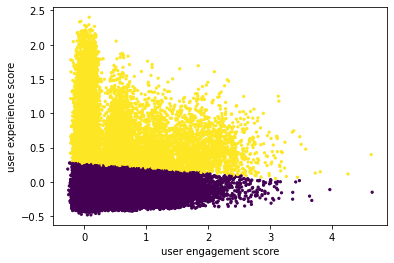

In [31]:
plt.scatter(x= ue_et_ux["ue_score"], y= ue_et_ux["ux_score"], c= ue_et_ux["labels"], s= 5)
plt.xlabel("user engagement score")
plt.ylabel("user experience score")

In [32]:
# the average scores per cluster
ue_et_ux.groupby("labels").mean()

,ux_score,ue_score
labels,,
0,-0.146175,0.233275
1,0.634332,0.389783


### Task 4.6 - Export your final table containing all user id + engagement, experience & satisfaction scores in your local MySQL database. Report a screenshot of a select query output on the exported table. 

In [33]:
to_db = satisfaction_data[["ux_score", "ue_score", "satisfaction_score"]].round(4)
to_db.index.name = "user_id"

In [34]:
to_db.to_csv(path + "scores.csv")

In [35]:
to_db.to_csv(path + "scores.csv")

In [36]:
from getpass import getpass
import mysql.connector

In [37]:
name = input("input username")
pswd = getpass("input password")
dbname = input("choose a name for the Database")

input username root
input password ···············
choose a name for the Database scores


In [38]:
# Connect to server
cnx = mysql.connector.connect(
    host= "localhost",
    user= name,
    password= pswd,
    # database = "scores"
)

# Get a cursor
cur = cnx.cursor()

In [95]:
cur.execute(f"CREATE DATABASE IF NOT EXISTS {dbname};")

cur.execute(f"USE {dbname};")

cur.execute(
"""CREATE TABLE IF NOT EXISTS scores (
user_id DOUBLE NOT NULL PRIMARY KEY,
ux_score FLOAT NOT NULL,
ue_score FLOAT NOT NULL,
satisfaction_score FLOAT NOT NULL
);"""
)

try:
    cur.execute(
    f"""LOAD DATA INFILE "{path}scores.csv" 
    INTO TABLE scores
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\r\n' 
    IGNORE 1 LINES 
    (user_id, ux_score, ue_score, satisfaction_score);"""
    )
except mysql.connector.errors.IntegrityError:
    print("DATA ALREADY LOADED INTO TABLE")   

cur.execute("select * from scores")
data = cur.fetchall()
data[:5]

# close connection 
cnx.close()

DATA ALREADY LOADED INTO TABLE


[(33601001722.0, -0.272, 0.1374, -0.0673),
 (33601001754.0, -0.3394, -0.0268, -0.1831),
 (33601002511.0, -0.0557, 0.121, 0.0326),
 (33601007832.0, -0.0979, -0.1329, -0.1154),
 (33601008617.0, 0.0647, 0.6191, 0.3419)]

### Task 4.7 Model deployment tracking- deploy the model and monitor your model. Here you can use Docker or other MlOps tools which can help you to track your model’s change.  Your model tracking report includes code version, start and end time, source, parameters, metrics (loss convergence), and artifacts or any output file regarding each specific run. (CSV file, screenshot)

In [97]:
import json

In [99]:
D= {
"maps": [
    {
        "id": 1,
        "iscategorical": False
    }
]}

In [100]:
type(D)

dict

In [108]:
D

{'maps': [{'id': 2, 'iscategorical': False}]}